
# Shared rides with pricing - Delft 

 ### Choice Function (Deterministic):
 `pool_price.py`
 * Pickup Distance: distance from driver initial position to the first pickup point
 * Travel Distance: distance from driver's initial position to the drop off point of the last passenger
 * Operating Cost: This include all the expenses
 * Profit: Driver revenue to serve the request
            
 
  ### KPI:
   
   * Profit of Individual driver
   * Profit of all the drivers
   * No.of rejected rides
   * U - PAX (Utility) 
  
   ### TBD- Choice Function (Probablistic):
  
  * choice logic to be applied inside `pool_price.py` 
  * P(R)= exp(beta * Profit_R)/ sum_all the rides( exp(beta * Profit_R)
 



In [23]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging
import matplotlib.pyplot as plt

import pandas as pd
import ExMAS


## Pricing for Delft, Netherlands

In [25]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

## Parameters for ExMAS

In [26]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 


13-02-23 23:02:01-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
13-02-23 23:02:01-INFO-creating combinations
13-02-23 23:02:01-INFO-90	 nR*(nR-1)
13-02-23 23:02:01-INFO-Reduction of feasible pairs by 95.56%
13-02-23 23:02:01-INFO-Degree 2 	Completed
13-02-23 23:02:01-INFO-trips to extend at degree 2 : 11
13-02-23 23:02:01-INFO-At degree 2 feasible extensions found out of 0 searched
13-02-23 23:02:01-INFO-Degree 3 	Completed
13-02-23 23:02:01-INFO-No more trips to exted at degree 3


In [27]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

13-02-23 23:02:01-INFO-Matching 10 trips to 21 rides in order to min u_pax
13-02-23 23:02:01-INFO-Problem solution: Optimal. 
Total costs for single trips:             53 
reduced by matching to:                   50


In [28]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.26350,176,1,[3.2635],"[0, 176]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44833175, 1421472390]","[None, 0, 0]",node time req_id od 0 ...,176,1.76,2.64750,0.52950,2.11800
1,[1],10.68350,577,1,[10.683499999999999],"[13, 577]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 5367742087, 1448535752]","[None, 1, 1]",node time req_id od 0 ...,577,5.77,8.66400,1.73280,6.93120
2,[2],1.94250,105,1,[1.9425],"[16, 105]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1413910863, 44822489]","[None, 2, 2]",node time req_id od 0 ...,105,1.05,1.57500,0.31500,1.26000
3,[3],1.30850,70,1,[1.3085],"[49, 70]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44840008, 5119770539]","[None, 3, 3]",node time req_id od 0 ...,70,0.70,1.06350,0.21270,0.85080
4,[4],4.91000,265,1,[4.91],"[89, 265]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1530303713, 4159110096]","[None, 4, 4]",node time req_id od 0 ...,265,2.65,3.98250,0.79650,3.18600
5,[5],4.65400,251,1,[4.654],"[95, 251]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,"[None, 1371031530, 3377240340]","[None, 5, 5]",node time req_id od 0 ...,251,2.51,3.77550,0.75510,3.02040
6,[6],3.26350,176,1,[3.2635],"[135, 176]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[None, 1571088337, 44819251]","[None, 6, 6]",node time req_id od 0 ...,176,1.76,2.64750,0.52950,2.11800
7,[7],6.96650,376,1,[6.9665],"[196, 376]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 44782877, 44848468]","[None, 7, 7]",node time req_id od 0 NaN...,376,3.76,5.65050,1.13010,4.52040
8,[8],7.99800,432,1,[7.997999999999999],"[221, 432]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[None, 610474431, 1584502763]","[None, 8, 8]",node time req_id od 0 ...,432,4.32,6.48600,1.29720,5.18880
9,[9],8.55600,462,1,[8.556000000000001],"[227, 462]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1385072823, 44859202]","[None, 9, 9]",node time req_id od 0 ...,462,4.62,6.93900,1.38780,5.55120


## Simulation with MaaSSim 

In [32]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

13-02-23 23:02:57-WARNING-Setting up 0.1h simulation at 2023-02-13 23:00:34 for 10 vehicles and 10 passengers in Delft, Netherlands
3
13-02-23 23:02:57-CRITICAL-this is request 0 with [0, 10, 11, 13] available rides.
13-02-23 23:02:57-CRITICAL-ride 0 available [1]
13-02-23 23:02:57-CRITICAL-ride 10 available [1, 0]
13-02-23 23:02:57-CRITICAL-ride 11 available [0, 1]
13-02-23 23:02:57-CRITICAL-ride 13 available [0, 1]
13-02-23 23:02:58-CRITICAL-this is reuqest 0 with [0, 10, 11, 13] still available rides.
13-02-23 23:02:58-CRITICAL-vehicle 1 has 4 choices
13-02-23 23:02:58-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 0 of degree 1, with travellers [0].
3
3
3
13-02-23 23:02:58-CRITICAL-this is request 3 with [3, 11] available rides.
13-02-23 23:02:58-CRITICAL-ride 3 available [1]
13-02-23 23:02:58-CRITICAL-ride 11 not available [1, 5]
13-02-23 23:02:58-CRITICAL-this is reuqest 3 with [3] still available rides.
3
13-02-23 23:02:58-CRITICAL-this is request 4 with [4, 12, 14

In [35]:
sim.res[0].pax_exp


,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,
0,15.0,245.0,20.0,30.0,243.0,100.0,0.0,10.0,0,0,0,0,0,0,245.0,343.0,55.0
1,15.0,577.0,20.0,30.0,302.0,0.0,13.0,10.0,0,0,0,0,0,0,577.0,302.0,55.0
2,15.0,105.0,20.0,30.0,76.0,0.0,16.0,10.0,0,0,0,0,0,0,105.0,76.0,55.0
3,15.0,70.0,20.0,30.0,0.0,0.0,49.0,10.0,0,0,0,0,0,0,70.0,0.0,55.0
4,9.0,390.0,20.0,30.0,185.0,6.0,89.0,10.0,0,0,0,0,0,0,390.0,191.0,49.0
5,9.0,251.0,26.0,30.0,294.0,89.0,6.0,10.0,0,0,0,0,0,0,251.0,383.0,49.0
6,15.0,197.0,35.0,30.0,427.0,0.0,120.0,10.0,0,0,0,0,0,0,197.0,427.0,55.0
7,15.0,486.0,4.0,30.0,518.0,16.0,196.0,10.0,0,0,0,0,0,0,486.0,534.0,55.0
8,15.0,432.0,20.0,30.0,492.0,0.0,221.0,10.0,0,0,0,0,0,0,432.0,492.0,55.0


In [37]:
sim.res[0].veh_exp


,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT,TRAVEL,WAIT,CRUISE,OPERATIONS,IDLE,PAX_KM,REVENUE
veh,,,,,,,,,,,,,,,,,,,,,
1,2.0,0.0,False,0,0,0.0,15.0,0,155.0,0,...,0,0,6735.0,197.0,0,397.0,230.0,5911.0,3.530,2.11800
2,0.0,0.0,False,0,0,227.0,0.0,0,0.0,0,...,0,0,7332.0,0.0,0,0.0,0.0,7332.0,0.000,0.00000
3,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
4,2.0,0.0,False,0,0,95.0,9.0,0,26.0,0,...,0,0,6830.0,275.0,0,264.0,95.0,6196.0,5.172,4.34448
5,1.0,0.0,False,0,0,16.0,15.0,0,20.0,0,...,0,0,7297.0,105.0,0,76.0,65.0,7051.0,1.050,1.26000
6,0.0,0.0,False,0,0,89.0,0.0,0,0.0,0,...,0,0,7470.0,0.0,0,0.0,0.0,7470.0,0.000,0.00000
7,1.0,0.0,False,0,0,13.0,15.0,0,20.0,0,...,0,0,6602.0,577.0,0,302.0,65.0,5658.0,5.776,6.93120
8,0.0,0.0,False,0,0,0.0,0.0,0,0.0,0,...,0,0,7559.0,0.0,0,0.0,0.0,7559.0,0.000,0.00000
9,3.0,0.0,False,0,0,61.0,30.0,0,71.0,0,...,0,0,6294.0,556.0,0,457.0,191.0,5090.0,9.102,7.05012


In [38]:
sim.res[0].all_kpi # All driver revenue 

26.8926

In [39]:
sim.res[0].veh_exp['REVENUE'].to_list()

[2.118,
 0.0,
 0.0,
 4.344479999999999,
 1.2600000000000002,
 0.0,
 6.9312,
 0.0,
 7.05012,
 5.1888]

In [40]:

list(sim.vehs.keys())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [41]:
sim.res[0].all_kpi

26.8926

## Plotting Graph of driver vs revenue

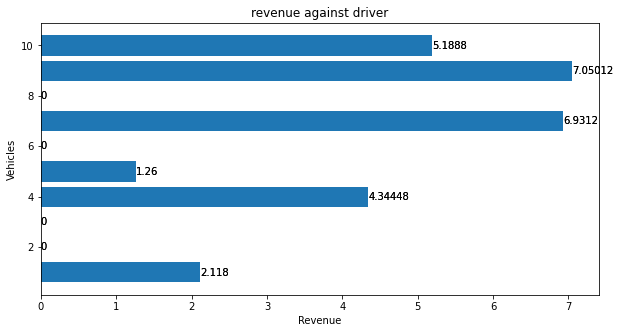

In [42]:
# plot graph of driver revenue
vehicles  = list(sim.res[0].veh_exp.index.to_list())
revenues = sim.res[0].veh_exp['REVENUE'].to_list()
fig, ax = plt.subplots(figsize = (10,5))
bars = ax.barh(vehicles, revenues)
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)


plt.xlabel("Revenue")
plt.ylabel("Vehicles")
plt.title("revenue against driver")
plt.show()

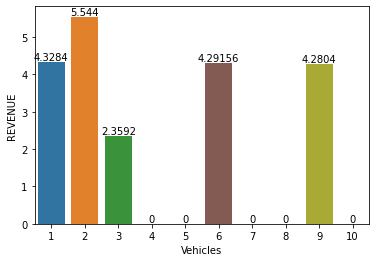

In [19]:
import seaborn as sns
sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

ax =sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE")
for i in ax.containers:
    ax.bar_label(i,)

In [20]:
Revenue
cost 

KDE plot 
driver events 


SyntaxError: invalid syntax (2789333649.py, line 4)

In [21]:
3 Strategies 

1. Profit maximization 
2. private only 
3. pooled rides only 



SyntaxError: invalid syntax (281713174.py, line 1)

In [28]:
import pandas as pd

df = pd.DataFrame(sim.res[0].veh_exp)
print(df)
df.to_csv(r'D:\Development\GitHub-ProjectV2.0\MaaSSim\docs\Experiments\export_dataframe.csv', index=False, header=True)


     nRIDES  nREJECTED    OUT  STARTS_DAY  OPENS_APP  RECEIVES_REQUEST  \
veh                                                                      
1       1.0        0.0  False           0          0               0.0   
2       1.0        0.0  False           0          0             245.0   
3       0.0        0.0  False           0          0               0.0   
4       0.0        0.0  False           0          0             170.0   
5       2.0        0.0  False           0          0             176.0   
6       0.0        0.0  False           0          0               0.0   
7       2.0        0.0  False           0          0             103.0   
8       2.0        0.0  False           0          0             126.0   
9       0.0        0.0  False           0          0             259.0   
10      2.0        0.0  False           0          0             104.0   

     ACCEPTS_REQUEST  REJECTS_REQUEST  IS_ACCEPTED_BY_TRAVELLER  \
veh                                         